In [1]:
%matplotlib qt

List of possible backends
GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template'

In [2]:
## Load libraries

import os
import numpy as np
import ase
from ase.visualize import view
from abtem.visualize import show_atoms
import abtem
from abtem.potentials.iam import Potential
#from abtem.measure import Measurement, Calibration
from abtem.measurements import PolarMeasurements
from abtem import Probe
import hyperspy.api as hs
import scipy
import matplotlib.pyplot as plt
import timeit
import copy
from tqdm.auto import tqdm

# Peak finding
#import atomap.api as am
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd

#From Chris
from imageEnhance import normImg
from imageEnhance import bwfilter
from imageEnhance import autoThresh

In [3]:
##To change the figure size
#plt.rcParams['figure.figsize'] = [12, 8]

In [4]:
# Increase default font size
plt.rcParams.update({'font.size': 16})

# STEM Simulation of GB-Cage

## Loop through simulation cells and simulate STEM images

In [5]:
folder = 'Data/STEM-simulations/'

files = [i for i in os.listdir(folder) if i.endswith(".xyz")]
cells = [os.path.join(folder, i) for i in files]
files

['36000_FullFe_x_rep_1.xyz',
 '36000_FullFe_x_rep_10.xyz',
 '36000_FullFe_x_rep_100.xyz',
 '36000_FullFe_x_rep_20.xyz',
 '36000_FullFe_x_rep_40.xyz',
 '36000_FullFe_x_rep_60.xyz',
 '36000_FullFe_x_rep_80.xyz',
 '36000_HalfFe_x_rep_1.xyz',
 '36000_HalfFe_x_rep_10.xyz',
 '36000_HalfFe_x_rep_100.xyz',
 '36000_HalfFe_x_rep_20.xyz',
 '36000_HalfFe_x_rep_40.xyz',
 '36000_HalfFe_x_rep_60.xyz',
 '36000_HalfFe_x_rep_80.xyz']

## Read atoms from simulation cell

In [6]:
from ase.io import read

file_index = 0
atoms = read(cells[file_index])

In [7]:
cell_dim = atoms.cell.cellpar()[:3]
cell_dim

array([ 4.6926999, 36.7655526, 91.4064026])

## Display simulation cell with ASE

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
show_atoms(atoms, plane='xy', ax=ax1)
show_atoms(atoms, plane='yz', ax=ax2)

(<Figure size 1924x1135 with 2 Axes>, <Axes: xlabel='y [Å]', ylabel='z [Å]'>)

In [9]:
# Determine atom coordinates along z-direction (beam direction)

atoms_pos = atoms.get_positions()
atoms_pos

array([[2.84635000e+00, 4.71353000e-01, 3.04071000e+01],
       [5.00000000e-01, 1.27265000e+01, 3.04071000e+01],
       [5.00000000e-01, 2.38919000e-05, 3.20399000e+01],
       [4.14347000e-01, 2.84129000e+00, 3.29593000e+01],
       [2.83507000e+00, 1.24503000e+00, 3.33465000e+01],
       [5.00000000e-01, 4.94921000e+00, 3.08153000e+01],
       [2.84635000e+00, 3.29947000e+00, 3.12235000e+01],
       [2.84635000e+00, 6.12759000e+00, 3.20399000e+01],
       [5.00000000e-01, 7.77733000e+00, 3.16317000e+01],
       [2.72028000e+00, 8.90176000e+00, 3.30701000e+01],
       [2.84635000e+00, 1.10768000e+01, 3.08153000e+01],
       [3.56409000e-01, 1.05653000e+01, 3.25751000e+01],
       [2.84635000e+00, 1.39049000e+01, 3.16317000e+01],
       [4.63560000e-01, 1.32817000e+01, 3.34128000e+01],
       [5.00000000e-01, 1.55547000e+01, 3.12235000e+01],
       [2.79112000e+00, 1.67705000e+01, 3.26508000e+01],
       [3.62088000e-01, 6.45283000e-01, 3.51284000e+01],
       [2.65429000e+00, 1.91420

In [10]:
# To change the order of axis: xyz ==> yzx 
atoms_pos[:, 1], atoms_pos[:, 2] = atoms_pos[:, 2], atoms_pos[:, 1].copy()
atoms_pos[:, 2], atoms_pos[:, 0] = atoms_pos[:, 0], atoms_pos[:, 2].copy()
atoms_pos

array([[4.71353000e-01, 3.04071000e+01, 2.84635000e+00],
       [1.27265000e+01, 3.04071000e+01, 5.00000000e-01],
       [2.38919000e-05, 3.20399000e+01, 5.00000000e-01],
       [2.84129000e+00, 3.29593000e+01, 4.14347000e-01],
       [1.24503000e+00, 3.33465000e+01, 2.83507000e+00],
       [4.94921000e+00, 3.08153000e+01, 5.00000000e-01],
       [3.29947000e+00, 3.12235000e+01, 2.84635000e+00],
       [6.12759000e+00, 3.20399000e+01, 2.84635000e+00],
       [7.77733000e+00, 3.16317000e+01, 5.00000000e-01],
       [8.90176000e+00, 3.30701000e+01, 2.72028000e+00],
       [1.10768000e+01, 3.08153000e+01, 2.84635000e+00],
       [1.05653000e+01, 3.25751000e+01, 3.56409000e-01],
       [1.39049000e+01, 3.16317000e+01, 2.84635000e+00],
       [1.32817000e+01, 3.34128000e+01, 4.63560000e-01],
       [1.55547000e+01, 3.12235000e+01, 5.00000000e-01],
       [1.67705000e+01, 3.26508000e+01, 2.79112000e+00],
       [6.45283000e-01, 3.51284000e+01, 3.62088000e-01],
       [1.91420000e+00, 3.59049

In [11]:
# Determine atom coordinates along z-direction (beam direction)
#eps = 0.01
#atoms_pos = atoms.get_positions()

# another way to change axis order in circular manner
#atoms_pos = np.roll(atoms_pos, [1, 1], axis=1)

# Shift atom positions : every position minus the minimum shifts atoms from negative to the positive side
atoms_pos_new = atoms_pos
atoms_pos_new[:, 0] = atoms_pos_new[:, 0] - np.min(atoms_pos_new[:, 0])
atoms_pos_new[:, 1] = atoms_pos_new[:, 1] - np.min(atoms_pos_new[:, 1])
atoms_pos_new[:, 2] = atoms_pos_new[:, 2] - np.min(atoms_pos_new[:, 2])

# Set new atom positions
atoms.set_positions(atoms_pos_new)

# Set new cell
atoms_pos = atoms.get_positions()
atoms.set_cell([np.max(atoms_pos[:, 0]), np.max(
    atoms_pos[:, 1]), np.max(atoms_pos[:, 2])])

# Set atom symbols to Ti
#atoms.symbols = 'Ti'

## Display reshaped simulation cell with ASE

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
show_atoms(atoms, plane='xy', ax=ax1)
show_atoms(atoms, plane='yz', ax=ax2)

(<Figure size 1924x1135 with 2 Axes>, <Axes: xlabel='y [Å]', ylabel='z [Å]'>)

In [13]:
cell_dim = atoms.cell.cellpar()[:3]
cell_dim

array([36.72675241, 21.1925    ,  4.125456  ])

### Replicate simulation cell along z-direction if required

In [14]:
#from ase.build import stack
#
#atoms_stack = stack(atoms, atoms, axis=2, maxstrain=None)
#print(atoms_stack)
#
#num_stacks = 2
#for a0 in range(num_stacks):
#    atoms_stack = stack(atoms, atoms_stack, axis=2, maxstrain=None)
#
#atoms = atoms_stack
#    
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
#show_atoms(atoms_stack, plane='xy', ax=ax1)
#show_atoms(atoms_stack, plane='yz', ax=ax2)

In [15]:
# Determine slice thickness
eps = 0.5
atoms_pos = atoms.get_positions()
atoms_z = np.round(atoms_pos[:,2],1)
cell_thickness = np.max(atoms_z) - np.min(atoms_z)
slice_thickness = np.min(atoms_z[atoms_z>eps])
print('Cell thickness in A:', cell_thickness)
print('Slice thickness in A:', slice_thickness)

Cell thickness in A: 4.1
Slice thickness in A: 0.6


## Commpute projected potential

In [16]:
from abtem.inelastic.phonons import FrozenPhonons

# Set up frozen phonon configurations
DWF_Ti_280K = 0.4911;
u_Ti_280K = np.sqrt(DWF_Ti_280K / (8*np.pi**2))

DWF_Fe_280K = 0.5330;
u_Fe_280K = np.sqrt(DWF_Fe_280K / (8*np.pi**2))

frozen_phonons = FrozenPhonons(atoms, 3, {'Ti' : u_Ti_280K, 'Fe' : u_Fe_280K}, seed=1001)

# Compute projected potential
projpot = Potential(frozen_phonons, sampling=.05, slice_thickness=slice_thickness, projection='infinite', parametrization='kirkland')
#precalc_pot = projpot.build(pbar=True)

# Using the GPU
##projpot = Potential(frozen_phonons, sampling=.05, slice_thickness=slice_thickness, projection='infinite', parametrization='kirkland', device='gpu')
##precalc_pot = projpot.build(pbar=True)

# Show projected potential
projpot.project().show()

[########################################] | 100% Completed | 2.46 ss


In [17]:
#Specify ADF semi-collection angles and beam scan grid 
detector = abtem.FlexibleAnnularDetector() #inner=78, outer=200, save_file=os.path.splitext(cells[file_index])[0] + '_gridscan_01.hdf5')
gridscan = abtem.GridScan(start=[15, 5], end=[25, 15], sampling=0.12)

# View the scan area
fig, ax = abtem.show_atoms(atoms)
#fig, ax = projpot.project().show()
gridscan.add_to_plot(ax)

## Set up the probe and start the simulation

In [18]:
probe = abtem.Probe(energy=300e3, semiangle_cutoff=24, defocus=0, device='cpu') #focal_spread=60
probe.grid.match(projpot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);

[########################################] | 100% Completed | 327.60 ms
[########################################] | 100% Completed | 103.60 ms


In [21]:
print(f"defocus = {probe.aberrations.defocus} Å")

defocus = 0 Å


In [20]:
flexible_measurement = probe.scan(projpot, scan=gridscan, detectors=detector)
flexible_measurement.compute()

[########################################] | 100% Completed | 12m 18s


In [35]:
## Using the GPU
#probe = Probe(energy=300e3, semiangle_cutoff=24, defocus=0, device='gpu') #focal_spread=60
#measurement_files = probe.scan(gridscan, [detector], projpot, pbar=True)

In [22]:
bf_measurement = flexible_measurement.integrate_radial(0, probe.semiangle_cutoff)
maadf_measurement = flexible_measurement.integrate_radial(50, 100)
haadf_measurement = flexible_measurement.integrate_radial(70, 140)

RuntimeError: Integration limit exceeded.

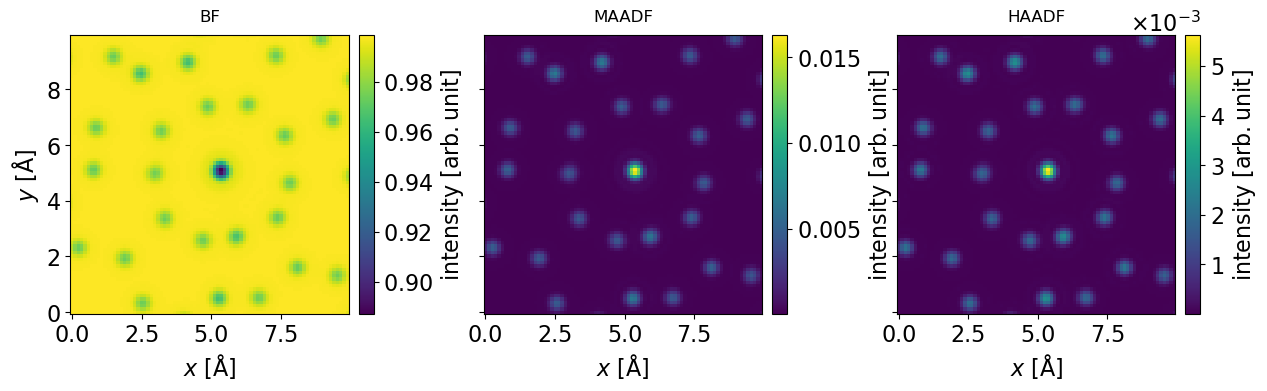

In [33]:
measurements = abtem.stack(
    [bf_measurement, maadf_measurement, haadf_measurement], ("BF", "MAADF", "HAADF")
)

measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

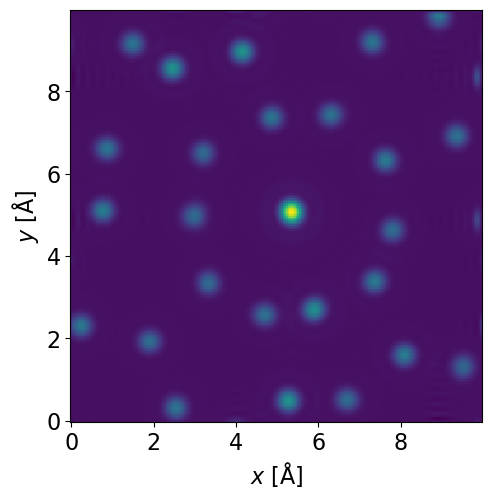

In [34]:
# To copy the measurement
new_measurement = measurements[2].tile((1, 1))

# Give the new sampling as input in interpolate to make the final image less blurred.
# Smaller sampling takes long computational time. 
# So we compute with 0.12 sampling but here interpolate to 0.04. 
# In other words, each pixel in the final image is 0.04 A wide.

# 10 A is the grid size, 10/0.04 = 250,

pixel_size = 0.04
new_measurement = new_measurement.interpolate(pixel_size)

new_measurement.show();

In [38]:
new_measurement

In [36]:
## To check the size of the generated output
#measurement.shape 
new_measurement.shape

(250, 250)

In [37]:
new_measurement.save_as_image(os.path.splitext(cells[file_index])[0] + '_01.png')

AttributeError: 'Images' object has no attribute 'save_as_image'

# To draw line profiles across the atomic columns

In [16]:
img = hs.load(os.path.splitext(cells[file_index])[0] + '.png')

#### Find sigma value of the central peak and all other peaks

In [17]:
img.data = img.data - img.data.min()

In [18]:
# Check peak separation with atomap
min_peak_separation = 7

# Get peak positions and determine sublattice
peak_pos = am.get_atom_positions(img, separation=min_peak_separation)
peak_pos = am.Sublattice(peak_pos, image=img.data)

# Refine peak positions using center of mass and 2D Gaussians based on NN distance
peak_pos.find_nearest_neighbors()
peak_pos.refine_atom_positions_using_center_of_mass()
peak_pos.refine_atom_positions_using_2d_gaussian()

#peak_pos.get_position_history().plot(navigator='signal')

peak_list = peak_pos.atom_list
num_peaks = np.shape(peak_list)
num_peaks = num_peaks[0]

peaks = np.zeros((num_peaks,5))
for i in range(num_peaks):
    peaks[i,:] = [peak_list[i].pixel_x, peak_list[i].pixel_y, 0, peak_list[i].sigma_x, peak_list[i].sigma_y]
    peaks[i,2] = img.data[int(round(peak_list[i].pixel_y)), int(round(peak_list[i].pixel_x))]

# Add labels to peaks for NN distance determination
# Add peak index for labeling
peak_ind = np.arange(0,peaks.shape[0])

#Prepare figure
fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(img.data, cmap='inferno')
plt.colorbar()
#plt.clim([0, 1])

plt.scatter(peaks[:, 0], peaks[:, 1], c='blue', s=5)

for i in range(peaks.shape[0]):
    plt.text(x=peaks[i,0]+2,y=peaks[i,1]+2,s=peak_ind[i], 
              fontdict=dict(color='blue',size=10))

#Create scale bar
scalebar = ScaleBar(dx = 4, units='pm', fixed_value= 200, fixed_units= "pm", box_color = "black", box_alpha=1, color="white", location = 4, font_properties = {"size": 12}, border_pad = 0.3, pad = 0.5)
ax.add_artist(scalebar)

#pixel_size = 0.04, units = 'A',

plt.axis('off')
#plt.colorbar()
plt.show()

Center of mass:   0%|          | 0/25 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/25 [00:00<?, ?it/s]

In [19]:
df = pd.DataFrame(peaks, columns=["x", "y", "intensity", "sigma x", "sigma y"])
df

,x,y,intensity,sigma x,sigma y
0,132.570560,126.467826,64878.0,10.451553,9.192173
1,131.297674,13.155652,52534.0,6.160708,6.048162
2,145.804025,69.867730,52396.0,5.486159,5.852201
3,103.034503,224.016045,49684.0,7.091813,7.514934
4,62.212061,213.132321,48779.0,5.917716,5.755752
5,19.230465,126.919065,46355.0,6.676881,6.554041
6,237.718124,31.847883,45700.0,6.277991,6.851059
7,232.285303,171.991835,45562.0,7.570100,7.361793
8,81.878555,161.096440,45200.0,6.792891,6.852331
9,21.111512,164.462087,44803.0,6.465991,6.582770


In [20]:
# Image has arbitrary intensity values. 
#To compare different images we first normalize every image.
# Here is a simple function to normalize an image.
def norm_img(img):
    
    #value of whatever pixel must be 1. Here we take mean of all Ti colmuns excluding Fe peak.
    x = df['intensity'][1:].mean()
    #x = 40000.0
    y = img.min() 
           
    #norm_img =  (img-y)/(x-y)
    norm_img = img/x
    return norm_img

In [21]:
img = norm_img(img.data)

In [22]:
img = hs.signals.Signal2D(img)

In [25]:
img.axes_manager[0].name = 'x'
img.axes_manager[1].name = 'y'

img.axes_manager[0].scale = pixel_size
img.axes_manager[1].scale = pixel_size

img.axes_manager[0].units = 'A'
img.axes_manager[1].units = 'A'

In [52]:
img.plot(cmap='inferno', colorbar=True, axes_off=True, title='')

In [53]:
# Give x1, y1, x2, y2 in A (axis units)
line_profile = hs.roi.Line2DROI(4.0,5.05,6.5,5.05, linewidth=0.1)

In [54]:
line_full_Fe = line_profile.interactive(img)
#line_full_Fe.plot()

In [55]:
img.plot(cmap='inferno', colorbar=False, axes_off=True, title='')

mc = hs.markers.line_segment(line_profile[0], line_profile[1], line_profile[2], line_profile[3],
                             color='blue', linewidth=4, alpha=0.6)
img.add_marker(mc)

In [56]:
line_full_Fe

<BaseSignal, title: , dimensions: (|64)>

In [44]:
plt.imsave(fname = 'd:/PhD/Paper_Vivek_Structure_Sigma13/Figures/Figures_02/GB-STEM-Simulation/Fe-full-norm-sim.png', arr = img.data, cmap='inferno')

In [319]:
plt.savefig('d:/PhD/Paper_Vivek_Structure_Sigma13/Figures/Figures_02/GB-STEM-Simulation/Fe-full-norm.png', bbox_inches='tight')

In [57]:
full_Fe_sigma = df['sigma x'][0]

In [58]:
full_Fe_x_mean = df['sigma x'][1:].mean()
full_Fe_x_std = df['sigma x'][1:].std()
print(f'The intensity of all other columns is {full_Fe_x_mean} + - {full_Fe_x_std}')

The intensity of all other columns is 6.623471741985852 + - 0.7036294082379638


### Input other images to plot line profiles across them.

In [28]:
img_half_Fe = hs.load(os.path.splitext(cells[-5])[0] + '.png')

In [29]:
img_half_Fe.data = img_half_Fe.data - img_half_Fe.data.min()

In [30]:
# Check peak separation with atomap
min_peak_separation = 7

# Get peak positions and determine sublattice
peak_pos = am.get_atom_positions(img_half_Fe, separation=min_peak_separation)
peak_pos = am.Sublattice(peak_pos, image=img_half_Fe.data)

# Refine peak positions using center of mass and 2D Gaussians based on NN distance
peak_pos.find_nearest_neighbors()
peak_pos.refine_atom_positions_using_center_of_mass()
peak_pos.refine_atom_positions_using_2d_gaussian()

#peak_pos.get_position_history().plot(navigator='signal')

peak_list = peak_pos.atom_list
num_peaks = np.shape(peak_list)
num_peaks = num_peaks[0]

Center of mass:   0%|          | 0/25 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/25 [00:00<?, ?it/s]

In [31]:
peaks = np.zeros((num_peaks,5))
for i in range(num_peaks):
    peaks[i,:] = [peak_list[i].pixel_x, peak_list[i].pixel_y, 0, peak_list[i].sigma_x, peak_list[i].sigma_y]
    peaks[i,2] = img_half_Fe.data[int(round(peak_list[i].pixel_y)), int(round(peak_list[i].pixel_x))]

# Add labels to peaks for NN distance determination
# Add peak index for labeling
peak_ind = np.arange(0,peaks.shape[0])

#Prepare figure
fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(img_half_Fe.data, cmap='inferno')
plt.colorbar()
#plt.clim([0, 1])

plt.scatter(peaks[:, 0], peaks[:, 1], c='blue', s=5)

for i in range(peaks.shape[0]):
    plt.text(x=peaks[i,0]+2,y=peaks[i,1]+2,s=peak_ind[i], 
              fontdict=dict(color='blue',size=10))

#Create scale bar
scalebar = ScaleBar(dx = 4, units='pm', fixed_value= 200, fixed_units= "pm", box_color = "black", box_alpha=1, color="white", location = 4, font_properties = {"size": 12}, border_pad = 0.3, pad = 0.5)
ax.add_artist(scalebar)

#pixel_size = 0.04, units = 'A',

plt.axis('off')
#plt.colorbar()
plt.show()

In [32]:
df = pd.DataFrame(peaks, columns=["x", "y", "intensity", "sigma x", "sigma y"])
df

,x,y,intensity,sigma x,sigma y
0,103.719376,223.051800,65535.0,7.428211,7.152312
1,132.081140,126.738574,64560.0,7.999460,8.091085
2,131.967314,11.454540,61423.0,6.358673,6.147233
3,61.777336,212.524121,60069.0,5.763019,5.410281
4,37.313894,227.517603,59664.0,5.326592,5.686215
5,145.949878,67.832912,59583.0,5.422943,5.942581
6,237.622430,33.324603,57572.0,6.691303,6.416925
7,116.576447,63.073525,57320.0,5.467391,5.951009
8,6.128049,56.257251,55897.0,7.318570,7.376903
9,81.484744,161.994002,56216.0,6.816449,7.148705


In [33]:
df['intensity'][1:].mean()

55698.166666666664

In [328]:
def norm_img_half(img):
    
    #value of whatever pixel must be 1. Here we take mean of all Ti colmuns excluding Fe peak.
    #x = df['intensity'][1:].mean()
    x = df['intensity'][1:].mean()
    y = img.min() 
           
    #norm_img =  (img-y)/(x-y)
    
    return norm_img

In [34]:
#Make sure the df is updated for the current image for norm_img to work correctly.
img_half_Fe = norm_img(img_half_Fe.data)

In [35]:
img_half_Fe = hs.signals.Signal2D(img_half_Fe)

In [36]:
img_half_Fe.axes_manager[0].name = 'x'
img_half_Fe.axes_manager[1].name = 'y'

img_half_Fe.axes_manager[0].scale = pixel_size
img_half_Fe.axes_manager[1].scale = pixel_size

img_half_Fe.axes_manager[0].units = 'A'
img_half_Fe.axes_manager[1].units = 'A'

In [59]:
img_half_Fe.plot(cmap='inferno', colorbar=True, axes_off=True, title='', vmax=1.45)

In [60]:
line_profile = hs.roi.Line2DROI(4.0,5.05,6.5,5.05, linewidth=0.1)

In [61]:
line_half_Fe = line_profile.interactive(img_half_Fe)
line_half_Fe.plot()

In [62]:
line_profile_02 = hs.roi.Line2DROI(1.95,6.5,4.45,6.5, linewidth=0.1)

In [63]:
line_half_Ti = line_profile_02.interactive(img_half_Fe)
line_half_Ti.plot()

In [47]:
img_half_Fe.plot(cmap='inferno', colorbar=False, axes_off=True, title='', vmax=1.45)

ma = hs.markers.line_segment(line_profile[0], line_profile[1], line_profile[2], line_profile[3],
                             color='darkorange', linewidth=4, alpha=0.6)
img_half_Fe.add_marker(ma)

mb = hs.markers.line_segment(line_profile_02[0], line_profile_02[1], line_profile_02[2], line_profile_02[3],
                             color='green', linewidth=4, alpha=0.6)
img_half_Fe.add_marker(mb)

In [188]:
plt.imsave(fname = 'd:/PhD/Paper_Vivek_Structure_Sigma13/Figures/Figures_02/GB-STEM-Simulation/Fe-half-sim-02.png', arr = img.data, cmap='inferno')

In [48]:
plt.savefig('d:/PhD/Paper_Vivek_Structure_Sigma13/Figures/Figures_02/GB-STEM-Simulation/Fe-half-sim-norm.png', bbox_inches='tight')

In [64]:
half_Fe_sigma = df.loc[1, "sigma x"]

In [65]:
half_Fe_x_mean = df.loc[2:,"sigma x"].mean()
half_Fe_x_std = df.loc[2:,"sigma x"].std()

print(f'The intensity of all other columns is {half_Fe_x_mean} + - {half_Fe_x_std}')

The intensity of all other columns is 6.563646185868646 + - 0.6540610299653578


### Draw profile across the experimental image

#### This failed because of too few pixels in experimental image

In [92]:
exp_img = hs.load('d:/PhD/PC_Titan/HuntStrucUnits/110a_49_ 1707 3.90 Mx HAADF-DF4 STEM 20201208.emd')
exp_img

In [95]:
exp_img[1].inav[-1].map(bwfilter, inc = 50, order = 8) #Default-20, 8
exp_img[1].inav[-1].map(scipy.ndimage.gaussian_filter, sigma=1.0, order=0, mode='wrap')
exp_img[1].inav[-1].map(autoThresh, stddev = 4) #Default-2.5

[########################################] | 100% Completed | 227.78 ms


In [98]:
exp_img[1].inav[-1].plot(cmap='inferno')

In [99]:
exp_dcfi = exp_img[1].inav[-1].isig[15.5:16.5, 4.1:5.12]

In [100]:
exp_dcfi.axes_manager.shape[0]

41

In [101]:
new_shape_num_pixels = 248
exp_dcfi_reshape = exp_dcfi.rebin(new_shape=[248, 248])
exp_dcfi_reshape

<Signal2D, title: DCFI, dimensions: (|248, 248)>

In [102]:
new_scale_binned = exp_img[1].inav[-1].axes_manager[0].scale/(new_shape_num_pixels/exp_dcfi.axes_manager.shape[0])

In [103]:
exp_dcfi_norm = norm_img(exp_dcfi_reshape.data)
exp_dcfi_norm = hs.signals.Signal2D(exp_dcfi_norm)

In [104]:
exp_dcfi_norm.axes_manager[0].name = 'x'
exp_dcfi_norm.axes_manager[1].name = 'y'

exp_dcfi_norm.axes_manager[0].scale = new_scale_binned*10
exp_dcfi_norm.axes_manager[1].scale = new_scale_binned*10

exp_dcfi_norm.axes_manager[0].units = 'A'
exp_dcfi_norm.axes_manager[1].units = 'A'

In [105]:
exp_dcfi_norm.plot(axes_off=True, cmap='inferno', colorbar=False)

In [107]:
line_profile_exp = hs.roi.Line2DROI(3.3, 5.25, 6.0, 5.25, linewidth=0.1)

In [108]:
line_exp = line_profile_exp.interactive(exp_dcfi_norm)

### Plot the line profiles

In [366]:
a1 = np.arange(0.0, 2.5, 0.038)
len(a1)

66

In [391]:
line_half_Fe

<BaseSignal, title: , dimensions: (|64)>

In [66]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.0, 2.5, 0.0395), line_full_Fe, label='Full-Fe', linewidth=3)
ax.plot(np.arange(0.0, 2.5, 0.0395), line_half_Fe, label='Half-Fe', linewidth=3)
ax.plot(np.arange(0.0, 2.5, 0.0395), line_half_Ti, label='Ti', linewidth=3, color='green', ls='--')

# Line profile across exp image doesn't have enough pixels. 
#ax.plot(line_exp, label='HAADF-STEM Exp.')
ax.legend(fontsize='medium')
ax.set_xlabel('Distance ($\AA$)', fontsize=16)
ax.set_ylabel('Intensity (a.u.)', fontsize=16)
#ax.set_yticks([])
#ax.set_yticklabels('')

ax.text(0, 1.30, '${{{\sigma_{Full-Fe}}}}$ =' + f'{round(full_Fe_sigma, 2)}', fontsize=16)
ax.text(0, 1.15, '${{{\sigma_{Half-Fe}}}}$ =' +  f'{round(half_Fe_sigma, 2)}', fontsize=16)
ax.text(0, 1.00, '${{{\sigma_{Ti}}}}$ =' + f'{round(half_Fe_x_mean, 2)}', fontsize=16)

Text(0, 1.0, '${{{\\sigma_{Ti}}}}$ =6.56')

In [68]:
fig.savefig('d:/PhD/Paper_Vivek_Structure_Sigma13/Figures/Figures_02/GB-STEM-Simulation/Line-plots-Fe-cage-simulations.png', bbox_inches='tight')

## To find the contribution of dechanneling in the Fe column: (from abTEM example)
### Suplementary (not discussed in the publication)

[20.34625241 10.1167    ]
[22.79308241  9.6297    ]


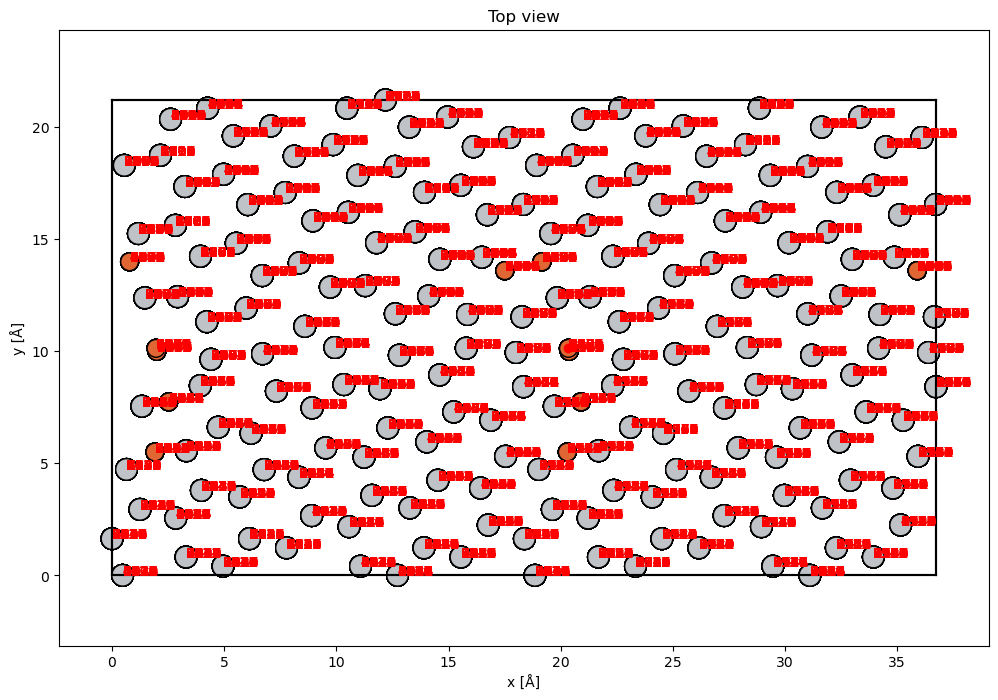

In [21]:
main_col = atoms.positions[145][:2] # x and y of main column
adj_col = atoms.positions[147][:2] # x and y of adjacent column
print(main_col)
print(adj_col)

show_atoms(atoms, title='Top view', scale_atoms=0.3);
ax = plt.gca()
ax.scatter(main_col[0], main_col[1], marker='o', c='r')

for i in range(len(atoms.positions)):
    x_p = atoms.positions[i][0]
    y_p = atoms.positions[i][1]
    ax.text(x= x_p, y= y_p, s= str(i), fontdict=dict(color='red', size=10))

### Use the index to pick the main_column and adj_col of interest

In [22]:
main_col = atoms.positions[145][:2] # x and y of main column
adj_col = atoms.positions[147][:2] # x and y of adjacent column
print(main_col)
print(adj_col)

[20.34625241 10.1167    ]
[22.79308241  9.6297    ]


In [23]:
probe_on_main_col = Probe(sampling=projpot.sampling,
                          gpts=projpot.gpts,
                          energy=300e3,
                          semiangle_cutoff=24,
                          focal_spread=60,
                          defocus=0,
                          device='gpu',
                         ).build(main_col) # placing probe at the top of a column

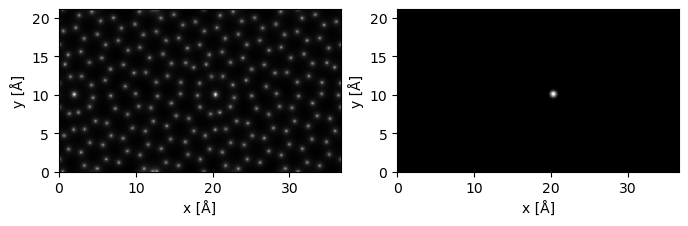

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
projpot.project().show(ax=ax1)
probe_on_main_col.show(ax=ax2);

In [25]:
def run_multislice(projpot, probe):
    
    probe_copy = copy.deepcopy(probe)
    n_slices = projpot.num_slices
    gpts = projpot.gpts
    waves = np.empty((n_slices, gpts[0], gpts[1]), dtype='float64')

    propagator = FresnelPropagator()

    for j in tqdm(range(n_slices)):
        projpot[j].transmit(probe_copy)
        propagator.propagate(probe_copy, dz=projpot[j].thickness)
        waves[j, :, :] = probe_copy.intensity().array
        
    return waves

In [26]:
propagation_main_col = run_multislice(projpot, probe_on_main_col)

  0%|          | 0/312 [00:00<?, ?it/s]

In [27]:
# create Calibration object for the z axis (thickness)
z_ax_calibration = Calibration(offset=0,
                               sampling=projpot.thickness/projpot.num_slices,
                               units='Å',
                               name='z')

calibrations = [z_ax_calibration] + list(projpot.project().calibrations)

In [28]:
measurement = Measurement(propagation_main_col, calibrations=calibrations)

In [29]:
main_col_signal = measurement.to_hyperspy().as_signal2D(image_axes=['x','y'])
main_col_signal

<Signal2D, title: , dimensions: (312|735, 424)>

In [30]:
cross_section = main_col_signal.transpose(signal_axes=['x','z']).inav[main_col[1]]
# take cross section on the x-z plane at the y position where the columns are located

intensity_1D = cross_section.transpose(navigation_axes=['x'])

main_col_intensity = intensity_1D.inav[main_col[0]]
main_col_intensity.metadata.General.title = 'Main column'

adj_col_intensity = intensity_1D.inav[adj_col[0]]
adj_col_intensity.metadata.General.title = 'Adjacent column'

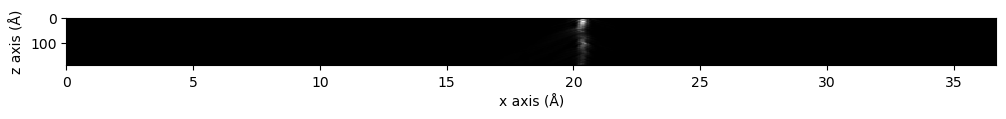

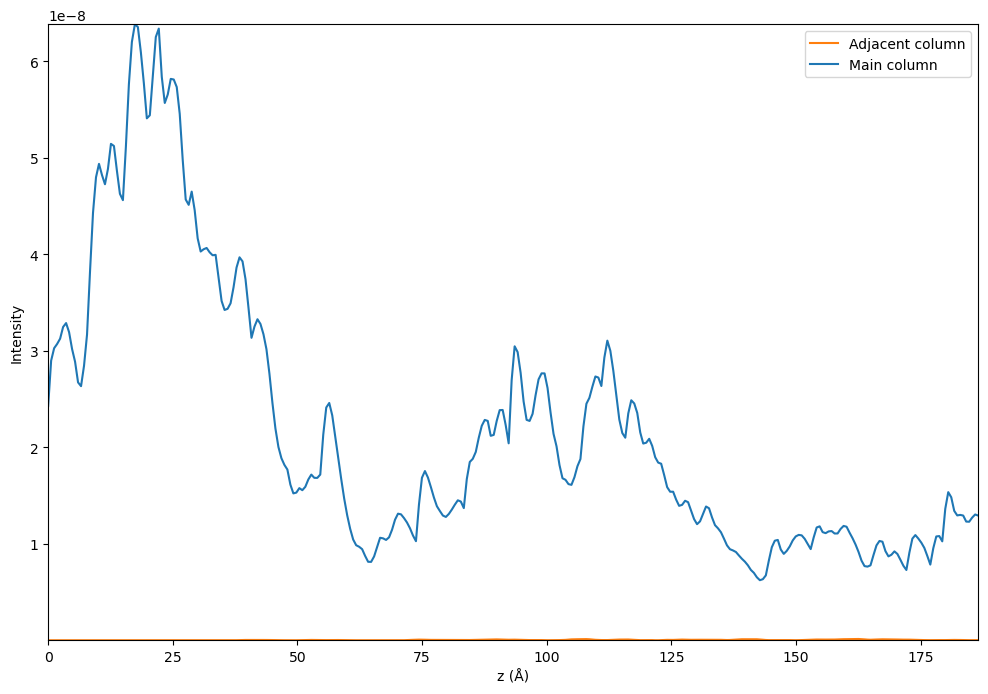

In [31]:
hs.plot.plot_images(cross_section, colorbar=False, suptitle='')
ax = plt.gca()
ax.set_aspect(0.01)

hs.plot.plot_spectra([main_col_intensity, adj_col_intensity], legend='auto');

## Placing probe between the atomic columns

In [32]:
probe_between_cols = Probe(sampling=projpot.sampling,
                          gpts=projpot.gpts,
                          energy=300e3,
                          semiangle_cutoff=24,
                          focal_spread=60,
                          defocus=0,
                          device='gpu',
                         ).build([(main_col[0]+adj_col[0]) / 2, main_col[1]]) # placing probe between columns

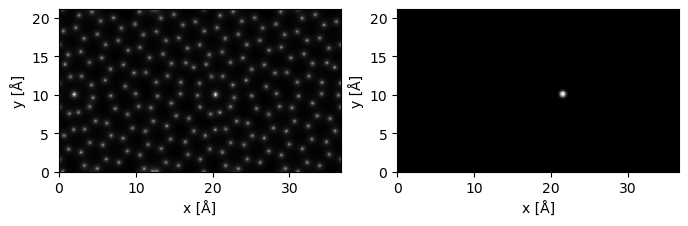

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
projpot.project().show(ax=ax1)
probe_between_cols.show(ax=ax2);

In [34]:
propagation_between_cols = run_multislice(projpot, probe_between_cols)

  0%|          | 0/312 [00:00<?, ?it/s]

In [35]:
between_cols_signal = Measurement(propagation_between_cols, calibrations=calibrations)
between_cols_signal = between_cols_signal.to_hyperspy().as_signal2D(image_axes=['x', 'y'])
between_cols_signal

<Signal2D, title: , dimensions: (312|735, 424)>

In [36]:
cross_section = between_cols_signal.transpose(signal_axes=['x','z']).inav[main_col[1]]
# take cross section on the x-z plane at the y position where the columns are located

intensity_1D = cross_section.transpose(navigation_axes=['x'])

main_col_intensity = intensity_1D.inav[main_col[0]]
main_col_intensity.metadata.General.title = 'Main column'

adj_col_intensity = intensity_1D.inav[adj_col[0]]
adj_col_intensity.metadata.General.title = 'Adjacent column'

midpoint_intensity = intensity_1D.inav[(main_col[0]+adj_col[0]) / 2]
midpoint_intensity.metadata.General.title = 'Midpoint'

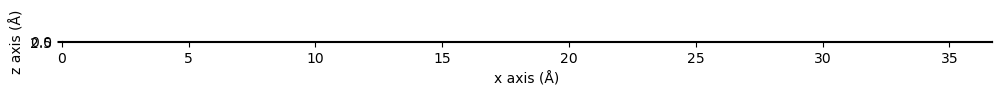

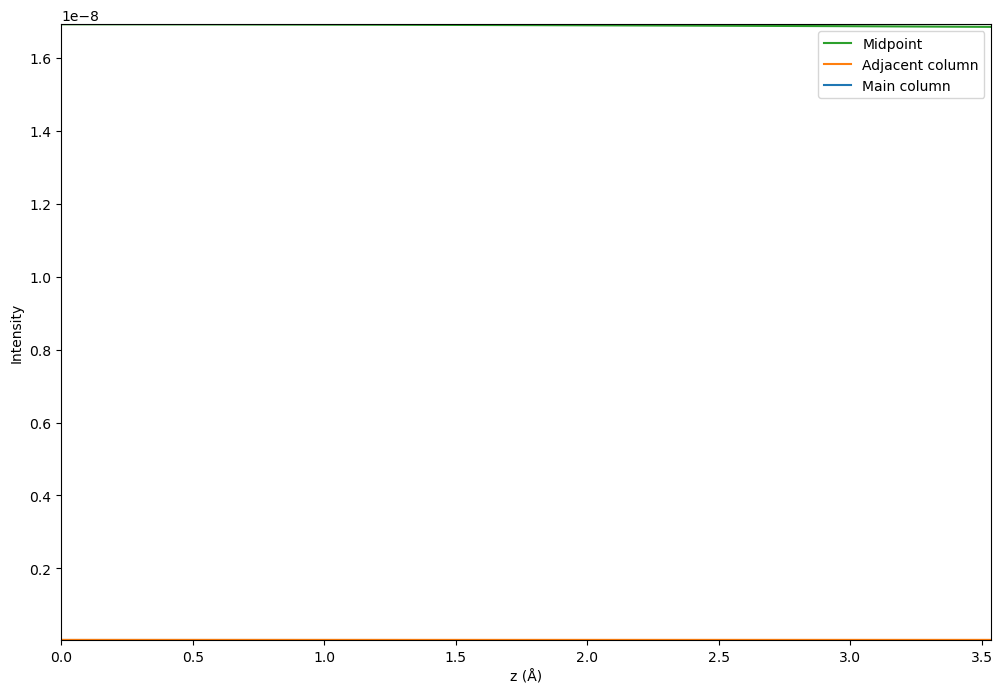

In [173]:
hs.plot.plot_images(cross_section, colorbar=False, suptitle='')
ax = plt.gca()
ax.set_aspect(0.01)

hs.plot.plot_spectra([main_col_intensity, adj_col_intensity, midpoint_intensity], legend='auto');